# Spatial analysis of variables on the hottest days
This takes the average over all days exceeding a given percentile at a given latitude and plots the spatial distribution of those days in a series of variables.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, frierson_atmospheric_heating
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, radius_earth
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_time_slice, annual_mean
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
from isca_tools.papers.byrne_2021 import get_quant_ind
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import numpy_indexed
from scipy.stats import percentileofscore
from scipy import interpolate, integrate

2023-06-02 09:03:07,160 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [111]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
# only keep variables required to compute relative humidity, MSE and miyawaki R1 value
var_keep = ['temp', 'sphum', 'vcomp', 'ucomp', 'omega', 'ps', 'height', 'precipitation', 'swdn_sfc', 'lwdn_sfc',
            'flux_t', 'flux_lhe', 't_surf']
tau_lw_ref = 0.2
tau_lw_warm = 6
pressure_ft = 500
use_time_start = 360*2
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf), drop=True)
    ds += [ds_use.sel(pfull=[pressure_ft, np.inf], method='nearest').load()]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
p_surface = float(ds[0].pfull[-1]) * 100

100%|██████████| 2/2 [00:46<00:00, 23.50s/it]


In [121]:
# For all days warmer than the quantile given at the given latitude: record time and longitude for each simulation
quant_use = 95
lat_use = 60
n_days = int(np.ceil((100-quant_use) *ds[0].lon.size * ds[0].time.size /100))
max_ind = {var: np.zeros((n_exp, n_days), dtype=int) for var in ['time', 'lon']}


# define maximum temperature - either surface or lowest level of atmosphere
# max_def = 'surf'
max_def = 'low'

for i in range(n_exp):
    ds_use = ds[i].sel(lat=lat_use,pfull=p_surface/100, method='nearest')
    ds_use = ds_use.temp if max_def == 'low' else ds_use.t_surf
    # get rid of last days over criteria if too many days - due to some days having same temperature, get this issue
    max_ind['time'][i] = np.where(ds_use.to_numpy()>=float(ds_use.quantile(quant_use/100)))[0][:n_days]
    max_ind['lon'][i] = np.where(ds_use.to_numpy()>=float(ds_use.quantile(quant_use/100)))[1][:n_days]
    # Maybe here, could do some sort of filtering to only include hottest day in a given time/lon period so don't get
    # lots of neighbouring points
lat_actual = float(ds_use.lat)
lat_ind = np.where(ds[0].lat==lat_actual)[0][0]

### Figure 2 - Time series of annual hottest days
Below, I try to replicate Figure 2 in the paper. For each year in the simulation, I find the hottest day in each region (I actually get 2 values for each year - one in northern hemisphere and one in southern hemisphere, as the hemispheres are equivalent). For each of these days, I keep track of some variables in the 10 days preceeding and 10 days after the hottest day.

The plots then show these variables averaged over all years.

In [122]:
def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1+w_sat)
    return q_sat

In [123]:
# Get all variables at surface and free troposphere on hottest day for each year considered
# Do separately for each hemisphere as should be indentical
# Keep all variables in a (2*spatial_sz['lat']+1) x (2*spatial_sz['lon']+1) size grid centered on location of hottest day
spatial_sz = {'lat':10, 'lon':10}
lat_ind_all =  np.arange(lat_ind-spatial_sz['lat'], lat_ind+spatial_sz['lat']+1)
if lat_ind_all.max() >= ds[0].lat.size:
    raise ValueError(f'Max latitude index is {lat_ind_all.max()}, which is out of range. Consider lowering spatial_sz')
lat_ind_all[lat_ind_all<0] += ds[0].lat.size
lat_ind_all[lat_ind_all>=ds[0].lat.size] -= ds[0].lat.size


var_ft = ['temp', 'height', 'ucomp', 'vcomp', 'omega']      # at surface and free troposphere
max_info = {var: np.zeros((n_exp, n_days, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds[0].pfull.size))
            for var in var_ft}
var_surf = ['sphum', 'rh', 'precipitation', 'ps', 'swdn_sfc', 'lwdn_sfc', 'flux_t', 'flux_lhe', 't_surf']
for var in var_surf:
    max_info[var] = np.zeros((n_exp, n_days, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1))

ind_use = {}
with tqdm(total=n_exp * n_days, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].isel(lat=lat_ind_all, drop=True)
        ds_use = ds_use.transpose(..., "pfull")         # put pfull at end so can add to max info
        for j in range(n_days):
            # Consider each year in turn
            lon_ind_all =  np.arange(max_ind['lon'][i, j]-spatial_sz['lon'], max_ind['lon'][i, j]+spatial_sz['lon']+1)
            # longitude is a circular index
            lon_ind_all[lon_ind_all<0] += ds_use.lon.size
            lon_ind_all[lon_ind_all>=lon_ind_all.size] -= ds_use.lon.size
            ds_use_j = ds_use.isel(time=max_ind['time'][i, j], lon=lon_ind_all, drop=True)
            for var in var_ft + var_surf:
                if var == 'sphum':
                    max_info[var][i, j] = ds_use_j[var].sel(pfull=np.inf, method='nearest')
                elif var!= 'rh':
                    max_info[var][i, j] = ds_use_j[var]
            pbar.update(1)
# compute near-surface relative humidity from specific humidity and near-surface temperature
max_info['rh'] = max_info['sphum'] / sphum_sat(max_info['temp'][:, :, :, :, -1], p_surface)
# Add empty axis to surface variables so same shape as surf+ft variables

for var in var_surf:
    if len(max_info[var].shape) != 6:
        max_info[var] = np.expand_dims(max_info[var], axis=-1)
# ft_ind = int(np.where(ds_max.pfull == pressure_ft_actual)[0])       # index of arrays corresponding to free troposphere

100%|██████████| 23040/23040 [00:47<00:00, 483.85it/s]


In [124]:
quant_info = {var: np.mean(max_info[var], axis=1) for var in max_info}
quant_info['ps'] = quant_info['ps']/100        # convert to hPa
quant_info['height'] = quant_info['height']/1000 # Convert to km
# Add empty pressure axis for all surface variables to make plotting easier
for var in quant_info:
    if len(quant_info[var].shape) == 3:
        quant_info[var] = np.expand_dims(quant_info[var], axis=-1)

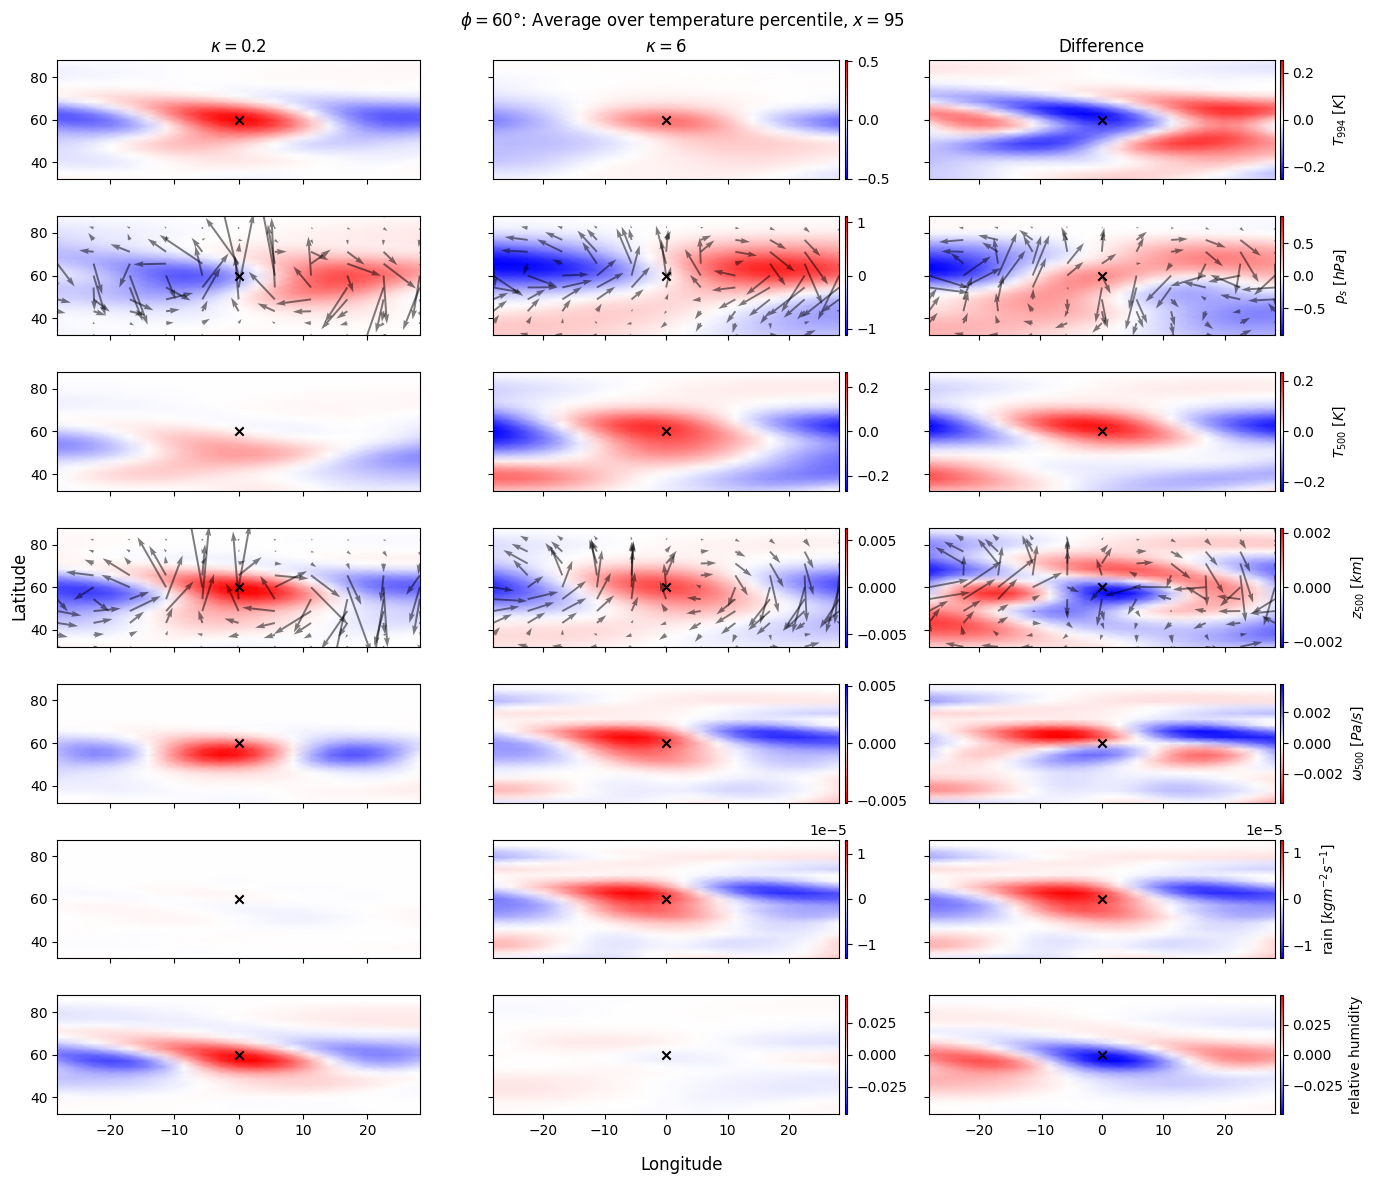

In [125]:
wind_spacing = 2    # larger means less dense arrows
cbar_param = {'aspect': 50, 'pad': 0.015, 'fraction': 0.03}

# centre longitude coordinates on 0
lon_plot = np.arange(-np.diff(ds_use_j.lon)[0]*10, np.diff(ds_use_j.lon)[0]*11, np.diff(ds_use_j.lon)[0])
lat_plot = ds_use_j.lat
max_coord = {'lat': lat_actual, 'lon':0}

var_plot = ['temp', 'ps', 'temp', 'height', 'omega', 'precipitation', 'rh']
var_p_ind = np.zeros(len(var_plot), dtype=int)
var_p_ind[:2] = -1   # first variable is at the surface
var_label = [f"$T_{'{'+str(int(p_surface/100))+'}'}$ [$K$]", '$p_s$ [$hPa$]', f"$T_{'{'+str(pressure_ft)+'}'}$ [$K$]",
             f"$z_{'{'+str(pressure_ft)+'}'}$ [$km$]", f"$\omega_{'{'+str(pressure_ft)+'}'}$ [$Pa/s$]", "rain [$kgm^{-2}s^{-1}$]",
             f"relative humidity"]


def plot_spatial(info, var_all, var_p, labels, rel_to_av=False, subtract_zonal_av=False):
    """
    Args:
        info: Dictionary, each variable is [n_exp, n_lat_spatial, n_lon_spatial, n_p_levels]
        var_all: [n_var_use] List of variables in info, that you want to plot.
        var_p: [n_var_use] List indicating pressure index to plot of all variables in var_all.
        labels: [n_var_use] Label to attach to colorbar for each variable
        rel_to_av: Whether info contains variables relative to the average day or not.
            If True, will use bwr colormap for each variable.
        subtract_zonal_av: For each latitude, subtracts the zonal average of the variable in info.
    """
    fig, ax = plt.subplots(len(var_all), 3, figsize=(14,12), sharex=True, sharey=True)
    for j, var in enumerate(var_all):
        for i in range(n_exp):
            ax[0, i].set_title(f'$\kappa = {tau_lw[i]}$')
            info_var = info[var][:, :, :, var_p[j]]
            if subtract_zonal_av:
                info_var = info_var - np.mean(info_var, axis=2, keepdims=True)
            if rel_to_av or subtract_zonal_av or var == 'omega':
                clims = [-np.nanmax(np.abs(info_var)),
                         np.nanmax(np.abs(info_var))]
                cmap = 'bwr_r' if var == 'omega' else 'bwr'
            else:
                clims = [np.nanmin(info_var),
                         np.nanmax(info_var)]
                cmap = 'viridis'
            im = ax[j, i].pcolormesh(lon_plot, lat_plot, info_var[i], shading='gouraud',
                                     vmin=clims[0], vmax=clims[1], cmap=cmap)
            ax[j, i].scatter(max_coord['lon'], max_coord['lat'], marker='x', color='k')
            if var in ['ps', 'height']:
                wind_var = {var: info[var][i, :, :, var_p[j]] for var in ['ucomp', 'vcomp']}
                if subtract_zonal_av:
                    # Also plot winds with zonal average removed if selected
                    for wind in wind_var:
                        wind_var[wind] = wind_var[wind] - np.mean(wind_var[wind], axis=1, keepdims=True)
                pu, pv = wind_var['ucomp'][::wind_spacing, ::wind_spacing], \
                    wind_var['vcomp'][::wind_spacing, ::wind_spacing]
                ax[j, i].quiver(lon_plot[::wind_spacing], lat_plot[::wind_spacing], pu, pv, alpha=0.5,
                                color='r' if cmap=='viridis' else 'k')
            if i == n_exp-1:
                plt.colorbar(im, ax=ax[j, i],
                             aspect=cbar_param['aspect'], pad=cbar_param['pad'], fraction=cbar_param['fraction'])
        var_diff = info[var][1, :, :, var_p[j]] - info[var][0, :, :, var_p[j]]
        if subtract_zonal_av:
            var_diff = var_diff - np.mean(var_diff, axis=1, keepdims=True)
        clims = [-np.nanmax(np.abs(var_diff)), np.nanmax(np.abs(var_diff))]
        im = ax[j, 2].pcolormesh(lon_plot, lat_plot, var_diff, shading='gouraud',
                                 vmin=clims[0], vmax=clims[1], cmap='bwr_r' if var=='omega' else 'bwr')
        ax[j, 2].scatter(max_coord['lon'], max_coord['lat'], marker='x', color='k')
        plt.colorbar(im, ax=ax[j, 2], label=labels[j],
                     aspect=cbar_param['aspect'], pad=cbar_param['pad'], fraction=cbar_param['fraction'])
        if var in ['ps', 'height']:
            wind_diff = {wind: info[wind][1, :, :, var_p[j]] - info[wind][0, :, :, var_p[j]] for wind in ['ucomp', 'vcomp']}
            if subtract_zonal_av:
                for wind in wind_diff:
                    wind_diff[wind] = wind_diff[wind] - np.mean(wind_diff[wind], axis=1, keepdims=True)
            pu, pv = wind_diff['ucomp'][::wind_spacing, ::wind_spacing], wind_diff['vcomp'][::wind_spacing, ::wind_spacing]
            ax[j, 2].quiver(lon_plot[::wind_spacing], lat_plot[::wind_spacing], pu, pv, alpha=0.5, color='k')
    ax[0, 2].set_title('Difference')
    fig.supxlabel('Longitude')
    fig.supylabel('Latitude')
    return fig
fig = plot_spatial(quant_info, var_plot, var_p_ind, var_label, subtract_zonal_av=True)
fig.suptitle(f'$\phi={lat_use}\degree$: Average over temperature percentile, $x={quant_use}$')
plt.tight_layout();

In [126]:
# Get summer datasets so you can make above plot relative to the average summer
# av_method = 'all'
av_method = 'summer'
summer_months_nh = [7, 8, 9]  # June, July, August
summer_months_sh = [1, 2, 3]  # Dec, Jan, Feb

ds_av = []
for i in range(n_exp):
    ds_use = ds[i].isel(lat=lat_ind_all, drop=True)     # only keep latitudes required for plotting
    if av_method == 'summer':
        ds_use = annual_time_slice(ds_use, include_months=summer_months_nh if lat_use>0 else summer_months_sh)
    ds_use = ds_use.mean(dim=['time', 'lon'])
    ds_use = ds_use.transpose('lat', 'pfull')

    # Add pressure dimension to surface variables to make latter plotting simpler
    for var in var_surf:
        if var != 'rh':
            if len(ds_use[var].shape) != 2:
                ds_use[var] = ds_use[var].expand_dims(dim={"pfull": 2}, axis=-1)
    ds_use['height'] = ds_use['height']/1000    # convert to km
    ds_use['ps'] = ds_use['ps']/100      # convert to hPa
    ds_av += [ds_use]

In [127]:
av_info = {}
quant_rel_info = {}
for var in quant_info:
    if var == 'rh':
        var_av = np.asarray([(ds_av[i]['sphum'] / sphum_sat(ds_av[i].temp, p_surface)).sel(pfull=[p_surface/100]) for i in range(n_exp)])
    else:
        var_av = np.asarray([ds_av[0][var], ds_av[1][var]])
    var_av = np.expand_dims(var_av, axis=2)     # add longitude axis
    quant_rel_info[var] = quant_info[var] - var_av
    av_info[var] = np.repeat(var_av, spatial_sz['lon']*2+1, axis=2)     # have same size in longitude as quant_info

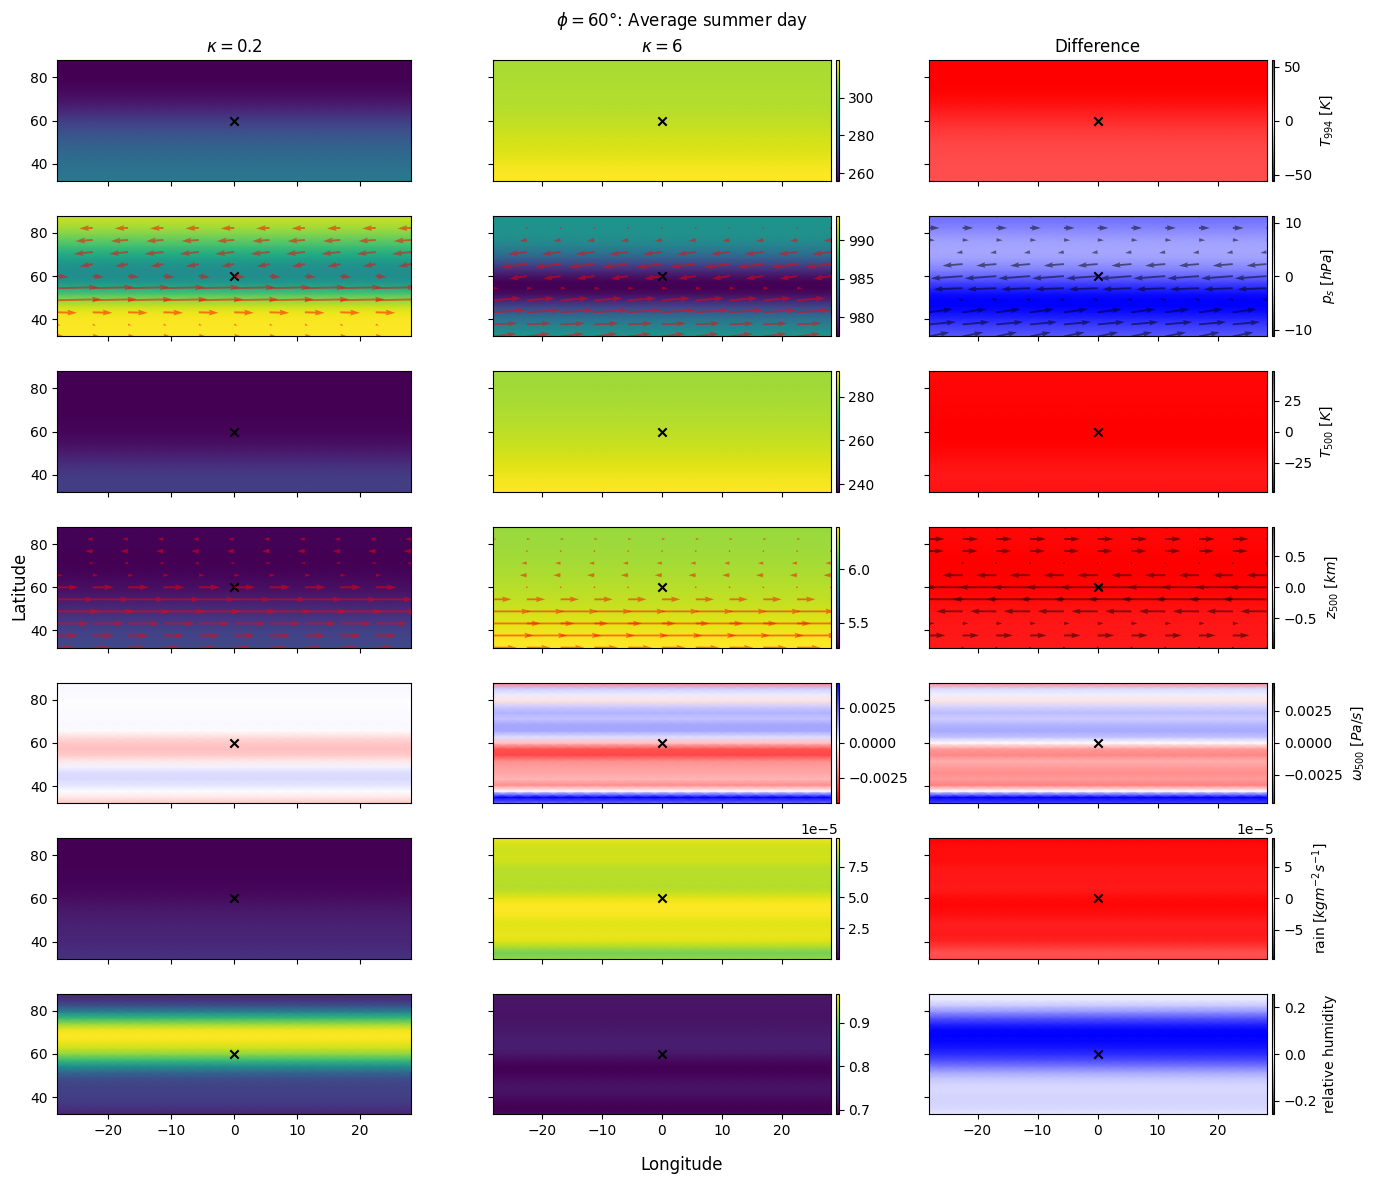

In [128]:
# Show how average summer day varies between the simulations
fig = plot_spatial(av_info, var_plot, var_p_ind, var_label)
fig.suptitle(f'$\phi={lat_use}\degree$: Average summer day')
plt.tight_layout();

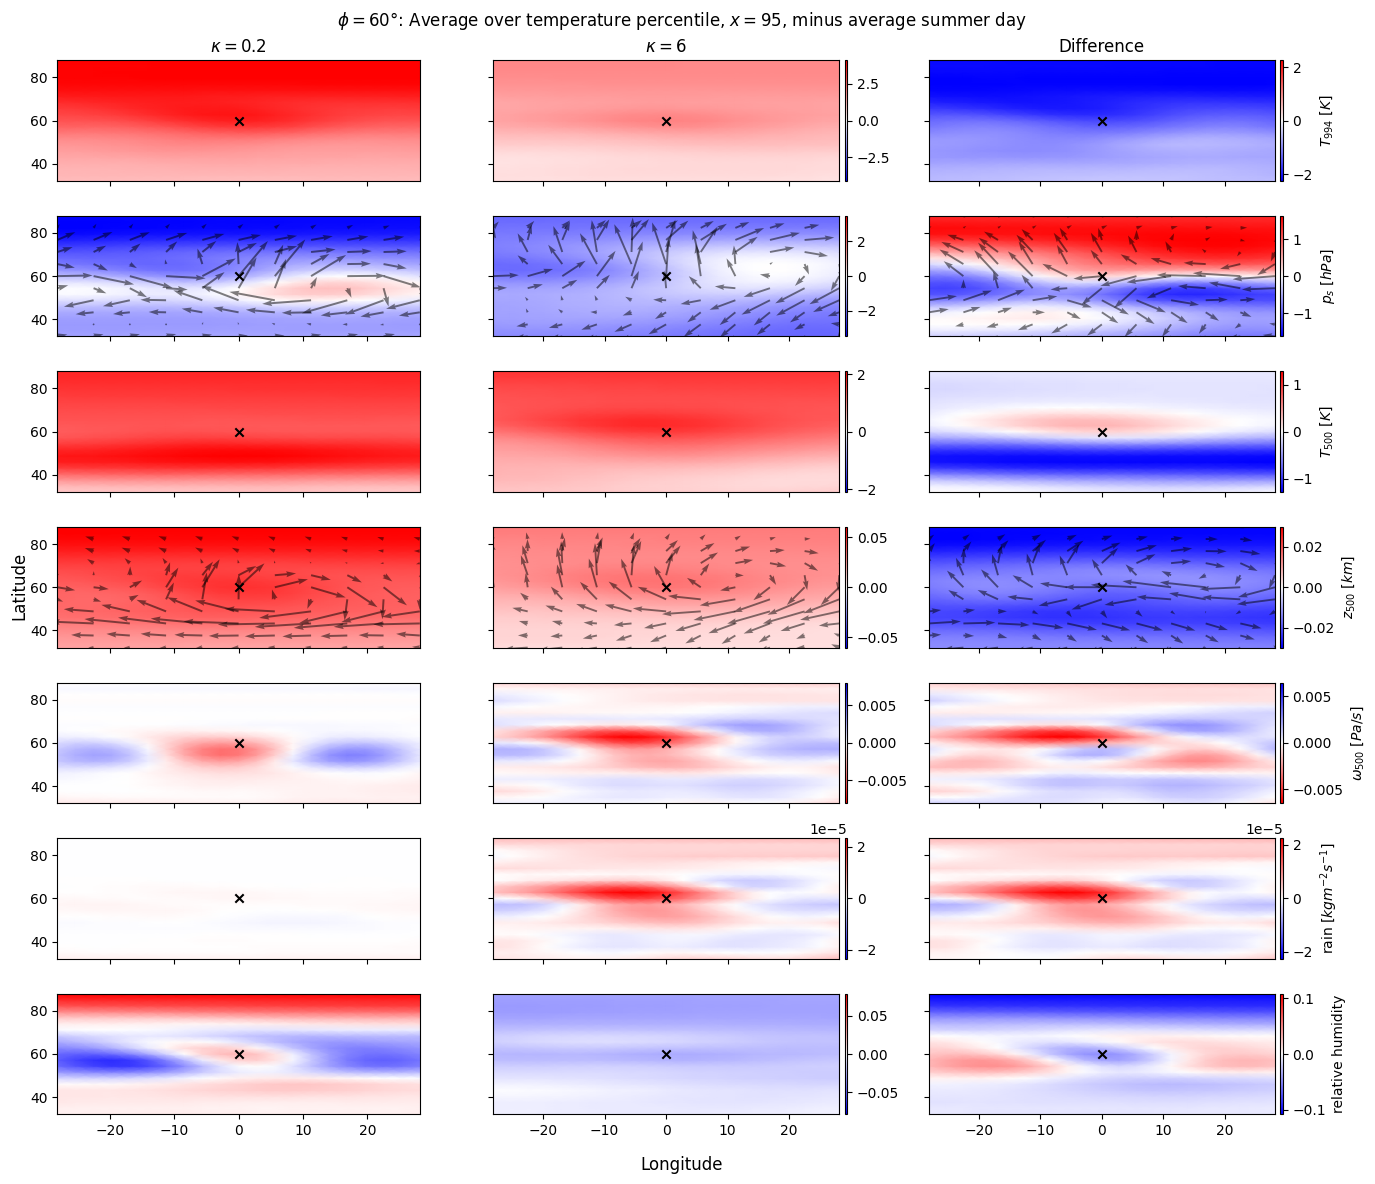

In [129]:
# Show how variables on hot days relative to summer mean vary between the simulations
fig = plot_spatial(quant_rel_info, var_plot, var_p_ind, var_label, rel_to_av=True)
fig.suptitle(f'$\phi={lat_use}\degree$: Average over temperature percentile, $x={quant_use}$, minus average summer day')
plt.tight_layout();